In [25]:
import numpy as np
import pandas as pd

from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.forest import RandomForestRegressor

import time
from datetime import datetime, timedelta

import utm
import geopy
from geopy.geocoders import Nominatim

import folium
from IPython.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# Travel Time predictor
class TaxiFarePredictor:
     
    def __init__(self, fname, TTmodel_type = 'RF', Fmodel_type = 'RF'):
        
        
        self.TTmodel_type = TTmodel_type # travel time model type
        self.Fmodel_type = Fmodel_type # fare predictor model type
        
        self.TTmodel = []
        self.Fmodel = []
        
        # load data and process features
        self.X, self.T, self.F = self.load_data(fname)
    
        # train travel time model
        self.travel_time_model(model_type = self.TTmodel_type)
        
        # train fare model
        self.fare_model(model_type = self.Fmodel_type)
     
    
    def load_data(self, fname):
        
        #  File structure must be 
        #
        #  0-4    ['ID', 'STARTDATE', 'ENDDATE', 'Total_amount', 'PASSENGER_NUM',
        #  5-10   'GPS_START_LO', 'GPS_START_LA', 'GPS_END_LO', 'GPS_END_LA', 'StartTAZ1454', 'TAZ1454_end]
        #
        trips = np.genfromtxt(fname, delimiter=',')
        features = np.zeros((trips.shape[0],11))

        with open(fname,'rU') as f: 

            for line in f: # go over data file, line by line

                l = line.split(',') # get a list of attributes, as strings

                # parse the time strings from %m/%d/%Y %H:%M format into seconds
                tto = datetime.strptime(l[1], "%m/%d/%y %H:%M")
                ttd = datetime.strptime(l[2], "%m/%d/%y %H:%M")

                # trip duration
                tdelta = time.mktime(ttd.timetuple()) - time.mktime(tto.timetuple())

                # convert to time since midnight
                to = (tto - tto.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
                td = (ttd - ttd.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

                # convert strings to floats
                l[5:10] = map(lambda x: float(x), l[5:10])

                # convert to meters in UTM
                o = np.array(utm.from_latlon(l[6], l[5])[:2])
                d = np.array(utm.from_latlon(l[8], l[7])[:2])

                # euclidean distance between origin and destination
                dist = cdist([o],[d])[0][0]

                # collect all features we have computed
                features[int(l[0]),:11] = np.append(np.array([int(l[0]), float(l[3]), td, tdelta, float(l[4]), to, dist]), np.append(o, d))
                
        # return X, travel time, fare          
        return features[:,4:], features[:,3], features[:,1]   
    
    
    def travel_time_model(self, model_type='RF'):
    
        if model_type == 'RF':
            self.TTmodel = RandomForestRegressor(random_state=0, n_estimators=50, max_depth=50)
            self.TTmodel.fit(self.X, self.T)
        else:
            print 'Unknown model type for travel times predictor.'
            
    
    def travel_time(self, Xq):
    
        return self.TTmodel.predict(Xq)
    
    
    def fare_model(self, model_type='RF'):
        
        T = self.T
        X = np.hstack( (self.X, np.array([self.T]).T ))
        
        if model_type == 'RF':
            self.Fmodel = RandomForestRegressor(random_state=0, n_estimators=50, max_depth=50)
            self.Fmodel.fit(X, self.F)  
        else:
            print 'Unknown model type for trip fare predictor.'
    
    
    def fare(self, Xq):
        
        return self.Fmodel.predict(Xq)

    
    # can take (lat, lon) pairs or address as text, via geolocator geocoding
    def TaxiFare(self, orig, dest, tstart='0:00', npax=1):
        
        if not isinstance(orig, basestring): 
            if not isinstance(dest, basestring): 
                
                o = np.array(utm.from_latlon(orig[1], orig[0])[:2])
                d = np.array(utm.from_latlon(dest[1], dest[0])[:2])
               
        else:
            
            try:
                geolocator = Nominatim()

                origin = geolocator.geocode(orig)
                destination = geolocator.geocode(dest)
    
                o = np.array(utm.from_latlon(origin.latitude, origin.longitude)[:2])
                d = np.array(utm.from_latlon(destination.latitude, destination.longitude)[:2])
            
            except:
                
                print 'Geocoding error. Try providing WGS84 coordinates instead.'
                
                return 0
            
        # euclidean distance between origin and destination
        dist = cdist([o],[d])[0][0]
    
        #print str(depart_s)
        temp = datetime.strptime('09/01/2012 '+ str(tstart), "%m/%d/%Y %H:%M")
        depart = (temp - temp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
        
        # features for travel time prediction
        xq = np.append(np.array([float(npax), depart, dist]), np.append(o, d))
                
        # predict travel time
        tt = self.travel_time(xq)
        
        # predict fare
        f = self.fare(np.append(xq, tt))
        
        return f[0], tt[0]

In [27]:
TFP = TaxiFarePredictor('train_set.csv')

In [28]:
type(TFP)

instance

In [29]:
cols = [1,5,6,7,8]

dev_set = pd.read_csv('dev_set.csv', header=None)
dev_set = dev_set[cols]
dev_set[1] = dev_set[1].str.split()
dev_set[1] = dev_set[dev_set.columns[0]].apply(lambda x: x[1])
dev_set_values = dev_set.values
dev_set.head()



,1,5,6,7,8
0,21:32,-122.384413,37.617068,-122.431757,37.744140
1,5:28,-122.399122,37.796990,-122.389815,37.614665
2,16:52,-122.384203,37.616892,-122.405625,37.785565
3,6:32,-122.442072,37.751618,-122.387693,37.617440
4,20:38,-122.417888,37.776878,-122.392063,37.694557


In [30]:
dev_set_final = [TFP.TaxiFare((item[1],item[2]), (item[3],item[4]), item[0]) for item in dev_set_values]

In [31]:
dev_zipped = zip(list(dev_set_final), list(dev_set_values))

dev_zipped[0]

((45.459200000000003, 1083.5999999999999),
 array(['21:32', -122.384413, 37.617067999999996, -122.431757, 37.74414], dtype=object))

In [32]:
test_set = pd.read_csv('Taxi_Query.csv', header=None)
test_set_values = test_set.values
test_set_values[0]

array([50001, '9/17/12 15:22', -1, -1, 1, -122.38679199999999, 37.61757,
       -122.39293700000002, 37.793532, 239, 0], dtype=object)

In [33]:
dev_set_fare = pd.read_csv('dev_set.csv', header=None)
dev_set_fare = dev_set_fare[3]
dev_set_fare = dev_set_fare.values

In [34]:
from sklearn.metrics import mean_squared_error
fare_pred = [item[0] for item in dev_set_final]
fare_true = [item for item in dev_set_fare]
mean_squared_error(fare_true, fare_pred)**0.5
# print(len(fare_pred))
# print(len(fare_true))
# print(fare_pred[0])
# print(fare_true[0])

5.1531979063490274

## Predict Final

In [35]:
TFP_final = TaxiFarePredictor('Taxi_Train.csv')

In [65]:
cols = [1,5,6,7,8]

query_set = pd.read_csv('Taxi_Query.csv', header=None)
query_set = query_set[cols]
query_set[1] = query_set[1].str.split()
query_set[1] = query_set[query_set.columns[0]].apply(lambda x: x[1])
query_set_values = query_set.values
query_set.head()

,1,5,6,7,8
0,15:22,-122.386792,37.617570,-122.392937,37.793532
1,22:08,-122.435182,37.762202,-122.438512,37.775893
2,19:49,-122.459563,37.790625,-122.410492,37.791650
3,15:53,-122.415940,37.800837,-122.431228,37.801518
4,15:20,-122.390272,37.615370,-122.417377,37.784307


In [37]:
query_set_final = [TFP.TaxiFare((item[1],item[2]), (item[3],item[4]), item[0]) for item in query_set_values]

In [38]:
query_set_fare = pd.read_csv('Taxi_Query.csv', header=None)
query_set_fare = query_set_fare[3]
query_set_fare = query_set_fare.values

In [39]:
raw_query = pd.read_csv('Taxi_Query.csv', header=None)
raw_query = raw_query[raw_query.columns[0]]
raw_query = raw_query.values
len(raw_query)

10000

In [40]:
fare_pred = [item[0] for item in query_set_final]
_id = raw_query

final_df = pd.DataFrame({"ID":_id, "Fare":fare_pred})
final_df = final_df[["ID","Fare"]]
# fare_true = [item for item in query_set_fare]
# mean_squared_error(fare_true, fare_pred)**0.5
# print(fare_pred[:10])
# print(fare_true[:10])
final_df.head()
final_df.to_csv("C263_koalakick.csv",index=False)

In [74]:
extra_query = pd.read_csv('Taxi_Query.csv', header=None)
extra_query[2] = fare_pred
extra_query[1] = extra_query[1].str.split()
extra_query[11] = extra_query[extra_query.columns[1]].apply(lambda x: x[0])
extra_query[12] = extra_query[extra_query.columns[1]].apply(lambda x: x[1])
extra_query[13] = extra_query[extra_query.columns[12]].apply(lambda x: x[:2])
extra_query.columns = ['index', 'full_date', 'fare', 'non1', 'non2', 'start_long', 'start_lat', 'end_long', 'end_lat', 'shit1', 'shit2','date','time','hour']
extra_query.head()
extra_query.to_csv("C263_extra_cred.csv",index=False)

## DONE DONE DONE ##

In [18]:
from sklearn.metrics import mean_squared_error
fare_pred = [item[0] for item in dev_set_final]
fare_true = [item for item in dev_set_fare]
mean_squared_error(fare_true, fare_pred)**0.5

5.1531979063490274

In [19]:
print TFP.TaxiFare( '1920, University Ave, Berkeley, CA', '1455 Market Street, SF', '8:20')
print TFP.TaxiFare( (-122.403023,37.792692), (-122.386232,37.618057), '3:27')

(40.064800000000012, 1836.0)
(47.024200000000008, 1192.8)


In [20]:
# abs(np.mean(cross_val_score(model_tf, fareX_train, fareY_train, cv=5, scoring='mean_squared_error')))**0.5

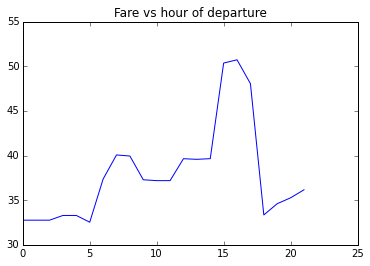

In [21]:
tt=[]
for i in range(1,23):
    tt.append( TFP.TaxiFare( '1920, University Ave, Berkeley, CA', '1455 Market Street, SF', '%d:20' % i, 1 ) )
    
plt.plot([t[0] for t in tt])
plt.title('Fare vs hour of departure')

In [22]:
def inline_map(fmap):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    fmap._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=fmap.HTML.replace('"', '&quot;')))

def embed_map(fmap, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    fmap.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

In [23]:
fmap = folium.Map(location=[37.802683, -122.41354], zoom_start=10)

start = '1920, University Ave, Berkeley, CA'
finish = 'Berkeley Marina' #'1455 Market Street, SF', 'Mountain View'
depart_at = '8:20'

f, t = TFP.TaxiFare( start, finish, depart_at )

geolocator = Nominatim()

origin = geolocator.geocode(start)
fmap.simple_marker([origin.latitude, origin.longitude], popup='Trip starts at %s' % depart_at)

destination = geolocator.geocode(finish)
fmap.simple_marker([destination.latitude, destination.longitude], popup='Taxi fare for your destination is $%.1f' % f)

inline_map(fmap)